In [1]:
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

In [2]:
import numpy as np
import pandas as pd
from os import listdir
from PIL import Image
from minisom import MiniSom
import pickle

from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['axes.grid'] = False
# plt.style.use('seaborn-v0_8-colorblind')

In [3]:
### Loading the features by name
features_by_name = pd.read_parquet(base_directory + 'original_features_by_name.parquet')
# features_by_name = features_by_name.dropna(axis=0)
# features_by_name = features_by_name.query("type in @qso_types")
### Sampling to save memory
# features_by_name = features_by_name.sample(frac=0.1)

### Loading the features by OID
features_by_oid = pd.read_parquet(base_directory + 'original_features_by_oid.parquet')
# features_by_oid = features_by_oid.dropna(axis=0)
# features_by_oid = features_by_oid.query("type in @qso_types")
### Sampling to save memory
# features_by_oid = features_by_oid.sample(frac=0.1)

In [4]:
### Loading the lightcurves by name
lightcurves_by_name = pd.read_pickle(base_directory + 'lightcurves_by_name_1day_binned.pkl')[['name', 'r_lightcurve','r_n_good_det','r_timespan_good','g_lightcurve','g_n_good_det','g_timespan_good']]
# lightcurves_by_name = lightcurves_by_name.dropna(axis=0)
# lightcurves_by_name = lightcurves_by_name.query("type in @qso_types")
### Sampling to save memory
# lightcurves_by_name = lightcurves_by_name.sample(frac=0.1)

### Loading the lightcurves by OID
lightcurves_by_oid = pd.read_pickle(base_directory + 'lightcurves_by_oid_1day_binned.pkl')[['oid_alerce', 'lightcurve','n_good_det','timespan_good']]
# lightcurves_by_oid = lightcurves_by_oid.dropna(axis=0)
# lightcurves_by_oid = lightcurves_by_oid.query("type in @qso_types")
### Sampling to save memory
# lightcurves_by_oid = lightcurves_by_oid.sample(frac=0.1)

In [5]:
features_by_name = features_by_name.merge(right=lightcurves_by_name, on='name', how='inner', suffixes=('feat', None))
features_by_oid = features_by_oid.merge(right=lightcurves_by_oid, on='oid_alerce', how='inner', suffixes=('feat', None))

In [6]:
feature_names = ['T2020_sigma2', 'mhps_ratio', 'mhps_low', 'mhps_high', 'Amplitude', 'AndersonDarling', 'Autocor_length',
                 'Beyond1Std', 'Con', 'Eta_e', 'Gskew', 'MaxSlope', 'Mean', 'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
                 'PercentAmplitude', 'Q31', 'PeriodLS_v2', 'Period_fit_v2', 'Psi_CS_v2', 'Psi_eta_v2', 'Rcs', 'Skew', 'SmallKurtosis',
                 'Std', 'StetsonK', 'Pvar', 'ExcessVar', 'GP_DRW_sigma', 'GP_DRW_tau', 'SF_ML_amplitude', 'SF_ML_gamma', 'IAR_phi',
                 'LinearTrend', 'Harmonics_mag_1', 'Harmonics_mag_2', 'Harmonics_mag_3', 'Harmonics_mag_4', 'Harmonics_mag_5',
                 'Harmonics_mag_6', 'Harmonics_mag_7', 'Harmonics_phase_2', 'Harmonics_phase_3', 'Harmonics_phase_4', 'Harmonics_phase_5',
                 'Harmonics_phase_6', 'Harmonics_phase_7', 'Harmonics_mse', 'mhps_non_zero', 'mhps_PN_flag']

band_feature_names = ['r_' + feature_name for feature_name in feature_names] + ['g_' + feature_name for feature_name in feature_names]
band_label_names = {i: feature_name for i, feature_name in enumerate(band_feature_names)}

In [7]:
### How big is data?
data = features_by_name[['type'] + band_feature_names]

print(f'There are {len(data)} rows in data right now.\n')
data['type'].value_counts()

There are 32163 rows in data right now.



type
Q     19613
A      3593
QX     2429
AX     1482
QR     1283
      ...  
NX        2
KX        1
K         1
KR        1
NR        1
Name: count, Length: 29, dtype: int64

In [ ]:
feature_ranges = {
    'T2020_sigma2': (0, 0.2),
    'mhps_ratio': (0, 1000),
    'mhps_low': (0, 2),
    'mhps_high': (0, 0.2),
    'SmallKurtosis': (0, 20),
    'ExcessVar': (0, 0.0004),
    'GP_DRW_sigma': (0, 0.3),
    'GP_DRW_tau': (0, 4000),
    'SF_ML_amplitude': (0, 2),
    'LinearTrend': (-0.003, 0.003),
    'Harmonics_mag_1': (0, 400),
    'Harmonics_mag_2': (0, 400),
    'Harmonics_mag_3': (0, 400),
    'Harmonics_mag_4': (0, 400),
    'Harmonics_mag_5': (0, 400),
    'Harmonics_mag_6': (0, 400),
    'Harmonics_mag_7': (0, 400),
    'Harmonics_mse': (0, 0.1)
}

for feature in feature_names:
    if feature in feature_ranges:
        range_min, range_max = feature_ranges[feature]
        data = data[(data['r_' + feature] >= range_min) & (data['g_' + feature] <= range_max)]

print(f'There are {len(data)} rows in data right now.\n')
data['type'].value_counts()

In [10]:
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

print(f'There are {len(data)} rows in data right now.\n')
data['type'].value_counts()

There are 19699 rows in data right now.



type
Q                          13159
A                           2085
QX                          1386
QR                           809
AX                           666
                           ...  
AR2                            5
A2X                            3
A2                             1
NR                             1
BL Lac-galaxy dominated        1
Name: count, Length: 25, dtype: int64

In [11]:
data_array = (data[band_feature_names] - np.mean(data[band_feature_names], axis=0)) / np.std(data[band_feature_names], axis=0)
data_array = data_array.values

In [ ]:
n_neurons = int(np.ceil(np.cbrt(data_array.shape[0])))
m_neurons = int(np.ceil(np.cbrt(data_array.shape[0])))
som = MiniSom(n_neurons, m_neurons, data_array.shape[1], sigma=1.5, learning_rate=.5, 
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')

som.pca_weights_init(data_array)
som.train(data_array, 10, verbose=False)  # random training

In [45]:
with open('/home/shoaib/ZTFDataChallenge/SOM/som.p', 'wb') as outfile:
    pickle.dump(som, outfile)

In [32]:
winner_coordinates = np.array([som.winner(x) for x in data_array]).T

In [33]:
cluster_index = np.ravel_multi_index(winner_coordinates, (9, 9))

In [37]:
np.unique(cluster_index)

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 73, 74, 75, 76, 77, 78, 79])

In [42]:
centroid.shape

(9, 104)

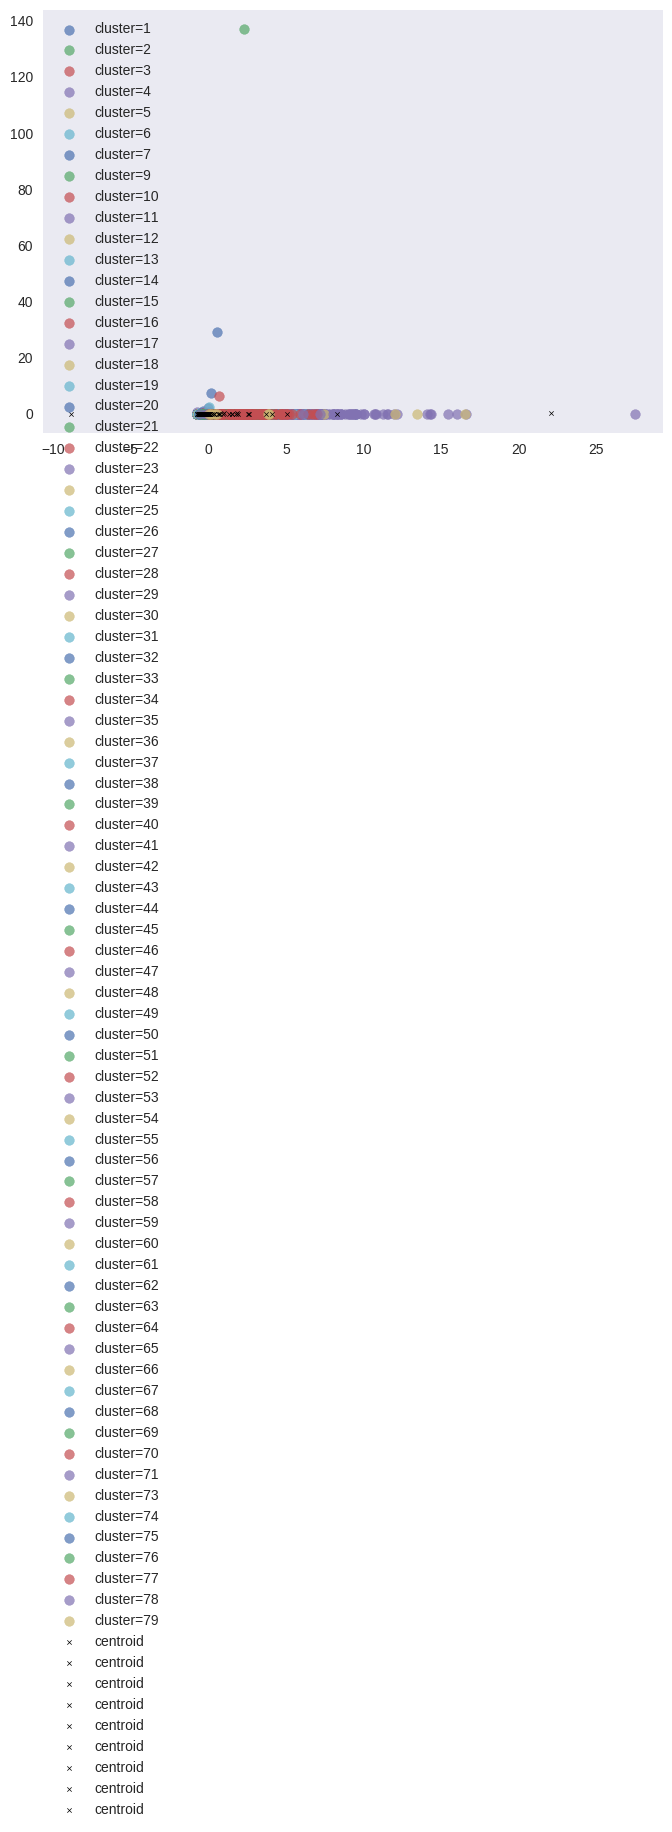

In [40]:
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data_array[cluster_index == c, 0],
                data_array[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=10, linewidths=0.5, color='k', label='centroid')
plt.legend()

In [50]:
'/'.join('/home/shoaib/ZTFDataChallenge/SOM/qnpy_clustering_with_SOM.py'.split('/')[:-1])

'/home/shoaib/ZTFDataChallenge/SOM'

In [49]:
data.shape

(19699, 105)

In [ ]:
for c in np.unique(cluster_index):
    plt.scatter(data_array[cluster_index == c, 0],
                data_array[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

In [51]:
data_array.shape

(19699, 104)

In [52]:
np.cbrt(19699)

np.float64(27.007313976485747)